In [1]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [73]:
#Configuring the IO structure:
W_size=3
st=4
et=22
Bin_size=1
prediction_size=1
n_features=280
irows=int(W_size/Bin_size)
icols=n_features
orows=int(prediction_size/Bin_size)
ocols=147
nipd=int((et-st)/Bin_size)-irows-orows+1

In [74]:
# Data Preparation
import pandas as pd

# Selecting data based on bin size
if Bin_size==0.5:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_30min_normed.csv',header =None)
if Bin_size==1:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_1Hr_normed.csv',header =None)
    
#Converting dataframe into matrix    
dataset=df2.as_matrix()

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [75]:
#Checking if the import is good to go:
if len(dataset)-1==34*18/Bin_size:
    print("Import successful!")

Import successful!


In [76]:
print(irows,orows)

3 1


In [77]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a multivariate sequence into samples and put them into X and y
X, y = list(), list()
def split_sequences(sequences, n_steps_in, n_steps_out):
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-2], sequences[end_ix:out_end_ix, :-2]
		X.append(seq_x)
		y.append(seq_y)
	return None

n_steps_in, n_steps_out = int(irows), int(orows)
rows_pday=int((et-st)/Bin_size)

# convert into input/output
for i in range(1,365):
    todays_df=dataset[(i-1)*rows_pday+1:i*rows_pday+1]
    split_sequences(todays_df, n_steps_in, n_steps_out)

#Check if the io sample count is valid:
if nipd*34==len(X)==len(y):
    print("IO Matrix creation successful!")
else:
    print("IO Matrix creation unsuccessful!")

IO Matrix creation successful!


In [78]:
#Filtering the Na IO matrices out
from math import isnan
import numpy as np
X_fil=np.array(X)
y_fil=np.array(y)
del_index=[]

# Noting down the index of Na matricesin del_index 
for i in range(len(X_fil)):
    del_index.append(np.any(np.isnan(X_fil[i])) or np.any(np.isnan(y_fil[i])))

# Filtering out the Na matrices from y_fil and X_fil by indexing using a list
y_fil=y_fil[list(~np.array(del_index))]
X_fil=X_fil[list(~np.array(del_index))]

# Check if the filtering is successful:
Na_count=0
for i in range(len(X_fil)):
    if np.any(np.isnan(y_fil[i]))==True & np.any(np.isnan(X_fil[i]))==True:
        Na_count=Na_count+1
if Na_count==0:
    print("Na Matrices filtered out sucessfuly!")
# y=np.array(y)
# for el in y[list(~np.array(deathlist))]:
#     print(np.any(np.isnan(Xtrial[i])))


Na Matrices filtered out sucessfuly!


In [79]:
# Normalizing the Input and output matrices.

In [80]:
# Print number of IO Pairs available:
print(len(y_fil)," I/O pairs available.")

289  I/O pairs available.


In [81]:
# Flatten output
n_output = y_fil.shape[1] * y_fil.shape[2]
y_fil = y_fil.reshape((y_fil.shape[0], n_output))

In [82]:
# Check the number of features
if n_features == X_fil.shape[2]:
    print("Good to go!")
else:
    print("Something wrong..")

Good to go!


In [83]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X_fil)) < 0.8
X_train = X_fil[msk]
y_train = y_fil[msk]
X_test = X_fil[~msk]
y_test = y_fil[~msk]
print("Dataset splitting done!")

Dataset splitting done!


In [84]:
# multivariate output multi-step 1d cnn example
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12
# fit model
history=model.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Number or epochs:",epochno)
print("Number of input features:",n_features)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available:",len(y_fil))
print("Model Mape loss:",model.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Number or epochs: 12
Number of input features: 280
Number of output features: 280
Bin size: 1
Window size: 3
Number of I/O pairs available: 289
59/59 [==============================] - 0s 66us/step
Model Mape loss: 1066.4628533832097
59/59 [==============================] - 0s 58us/step
Model MSE loss (Minimized): 0.003921484251080428
59/59 [==============================] - 0s 156us/step
RMSE loss: 0.0626217554135975


dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])


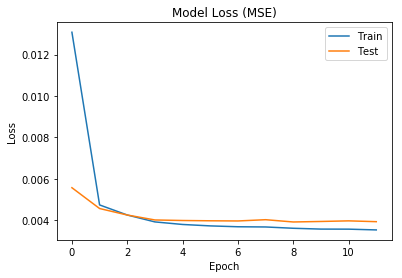

In [86]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#axes = plt.gca()
#axes.set_ylim([7500,0.2*100000])
#axes.set_xlim([1500,3000])
plt.show()

In [87]:
#history=model.fit(X, y, epochs=3000, verbose=1)
#model.evaluate(X,y)

In [139]:
# Plot a random Prediction vs actual travel time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(98)
rnd=np.random.randint(len(X_test))
print(rnd)
print()
# Demonstrate Prediction
x_input = X_test[rnd]
x_input = x_input.reshape((1, irows, n_features))
yhat = model.predict(x_input, verbose=0)
y_output = y_test[rnd]
#print(len(yhat[0]))
pdt=yhat[0]
act=y_output
if len(pdt)==len(act):
    print("Lengths match good to go!")

26

Lengths match good to go!


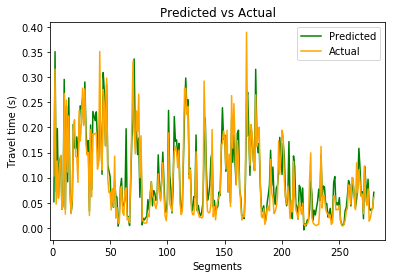

In [140]:
import matplotlib.pyplot as plt
import numpy

x=list(range(1,len(pdt)+1))
plt.plot(x, pdt[0:], color='g',label="Predicted")
plt.plot(x, act[0:], color='orange',label="Actual")
plt.xlabel('Segments')
plt.ylabel('Travel time (s)')
plt.title('Predicted vs Actual')
axes = plt.gca()
#axes.set_ylim([0,180])
axes.set_xlim([-2,len(pdt)+10])
leg = plt.legend();
#plt.show()

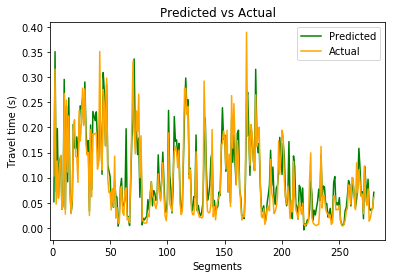

In [141]:
import matplotlib.pyplot as plt
import numpy

x=list(range(1,len(pdt)+1))
plt.plot(x, pdt[0:], color='g',label="Predicted")
plt.plot(x, act[0:], color='orange',label="Actual")
plt.xlabel('Segments')
plt.ylabel('Travel time (s)')
plt.title('Predicted vs Actual')
axes = plt.gca()
#axes.set_ylim([0,180])
axes.set_xlim([-2,len(pdt)+10])
leg = plt.legend();
#plt.show()

In [108]:
#Scaling the IO values and then determining MSE and shit
import pandas as pd

# Selecting data min-max data
Minmax = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Minmax.csv')


In [132]:
Minmax.drop(["V281"],axis=1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280
0,897.360325,188.40327,306.813182,72.432057,272.818406,123.361342,65.751376,188.602870,120.621274,21.351584,...,265.647755,55.580870,83.600332,112.036913,77.206680,246.622206,135.811515,188.549021,226.131446,178.863463
1,15.689489,2.78523,2.785230,2.785230,2.007044,2.007044,2.007044,2.007044,2.354105,2.495850,...,2.371096,2.183467,2.183467,2.183467,2.183467,3.328792,4.341340,5.110755,4.062942,3.598875


In [146]:
from sklearn.metrics import mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pdt_cor=[i for i in range(280)]
act_cor=[i for i in range(280)]
i=0
for col in Minmax.drop(["V281"],axis=1):
    mn=Minmax[col][1]
    mx=Minmax[col][0]
    pdt_cor[i]=(pdt[i]*(mx - mn))+mn
    act_cor[i]=(act[i]*(mx - mn))+mn
    i=i+1
    


MSE Error: 48.80224685989922
RMSE Error: 6.985860495307591
MAPE Error: 26.197346692198774


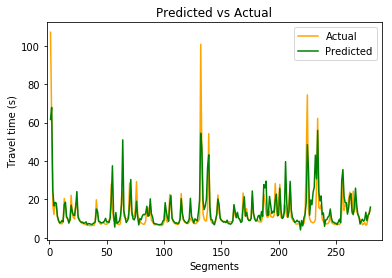

In [149]:
import matplotlib.pyplot as plt
import numpy

x=list(range(1,len(pdt)+1))
plt.plot(x, act_cor[0:], color='orange',label="Actual")
plt.plot(x, pdt_cor[0:], color='g',label="Predicted")
plt.xlabel('Segments')
plt.ylabel('Travel time (s)')
plt.title('Predicted vs Actual')
axes = plt.gca()
#axes.set_ylim([0,180])
axes.set_xlim([-2,len(pdt)+10])
leg = plt.legend();
#plt.show()

print("MSE Error:",mean_squared_error(act_cor,pdt_cor))
print("RMSE Error:",np.sqrt(mean_squared_error(act_cor,pdt_cor)))
print("MAPE Error:",mean_absolute_percentage_error(act_cor,pdt_cor))
